# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        #print(x.shape)
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [5]:
c = torch.rand(1,3, 32, 32)
d = Flattener().forward(c)
print(d.size())

c = torch.rand(3, 32, 32)
d = Flattener().forward(c)
print(d.size())

c = torch.rand(1, 3072)
d = Flattener().forward(c)
print(d.size())

torch.Size([1, 3072])
torch.Size([3, 1024])
torch.Size([1, 3072])


In [6]:
for i, a in enumerate(train_loader):
    print(a[0].size())
    break

torch.Size([64, 3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [7]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [8]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
            scheduler.step()
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy_and_loss(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    accuracy = 0
    total = 0 
    for (x, y) in loader:
        prediction = model(x)
        _,predicted = torch.max(prediction, 1)
        total+= x.size()[0]
        accuracy += (predicted == y).sum().item()
    #raise Exception("Not implemented")
    
    return accuracy/total

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.812824, Train accuracy: 0.419838, Val accuracy: 0.521398
Average loss: 1.450148, Train accuracy: 0.589035, Val accuracy: 0.606853
Average loss: 1.374348, Train accuracy: 0.621967, Val accuracy: 0.616681


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [9]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-3)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.352357, Train accuracy: 0.557434, Val accuracy: 0.678315
Average loss: 0.919863, Train accuracy: 0.713749, Val accuracy: 0.703433
Average loss: 0.809644, Train accuracy: 0.750742, Val accuracy: 0.712306
Average loss: 0.744384, Train accuracy: 0.772156, Val accuracy: 0.734148
Average loss: 0.699184, Train accuracy: 0.784186, Val accuracy: 0.755102


Добавьте слой с Batch Normalization

In [10]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-3)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.327062, Train accuracy: 0.568423, Val accuracy: 0.651355
Average loss: 0.945618, Train accuracy: 0.703733, Val accuracy: 0.715719
Average loss: 0.836191, Train accuracy: 0.740078, Val accuracy: 0.712306
Average loss: 0.772744, Train accuracy: 0.760878, Val accuracy: 0.775647
Average loss: 0.729240, Train accuracy: 0.775364, Val accuracy: 0.769231


Добавьте уменьшение скорости обучения по ходу тренировки.

In [11]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-3)
sch=torch.optim.lr_scheduler.StepLR(optimizer, 2)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5,sch )

Average loss: 1.336665, Train accuracy: 0.561734, Val accuracy: 0.676541
Average loss: 0.950684, Train accuracy: 0.702675, Val accuracy: 0.732305
Average loss: 0.721064, Train accuracy: 0.780193, Val accuracy: 0.790594
Average loss: 0.682355, Train accuracy: 0.793059, Val accuracy: 0.792028
Average loss: 0.650705, Train accuracy: 0.803348, Val accuracy: 0.800628


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [12]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    ground_truth = np.zeros(len(indices),np.int)
    predictions = np.zeros(len(indices),np.int)
    X = torch.zeros(len(indices))
    #raise Exception("Not implemented")
    for i_step, index in enumerate(SubsetSampler(indices)):
        ground_truth[i_step] = int(dataset[index][1])
        prediction = model(dataset[index][0].view(1, -1))
        _,predicted = torch.max(prediction, 1)
        predictions[i_step] = int(predicted)
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices) 
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

In [13]:
print(val_history)
assert np.sum(np.array(predictions) == np.array(gt))/len(predictions) == val_history[-1]

[0.6765408504538939, 0.7323049621186267, 0.7905944986690329, 0.792027847928469, 0.8006279434850864]


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

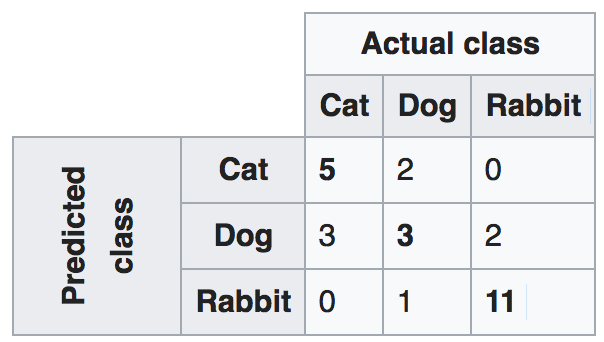

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

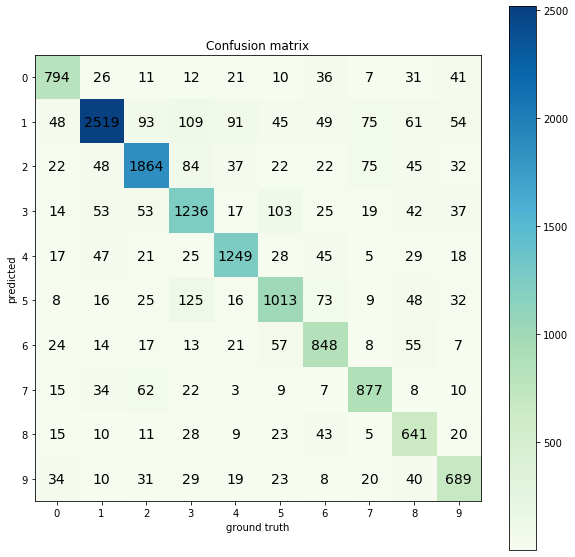

In [14]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    for step in range(len(ground_truth)):
        confusion_matrix[predictions[step]][ground_truth[step]]+=1
    
    # TODO: Implement filling the prediction matrix
    return confusion_matrix
    #return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

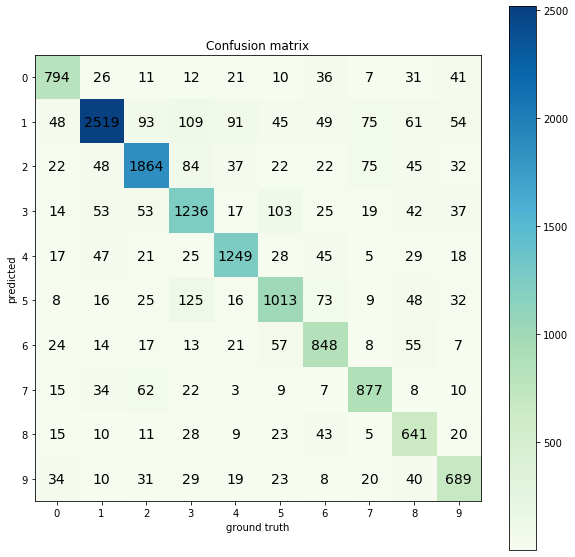

In [15]:
from sklearn.metrics import confusion_matrix
visualize_confusion_matrix(confusion_matrix(gt, predictions).T) #в scklearn наоборот 

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

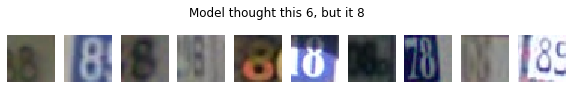

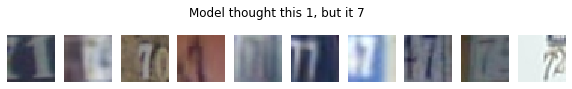

In [16]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    
    
    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    indices = val_indices[(predicted_class == predictions) & (groud_truth == gt_class)]
    visualize_images(indices, data, f"Model thought this {predicted_class}, but it {gt_class}")
    
    
    #raise Exception("Not implemented")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

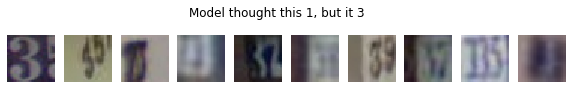

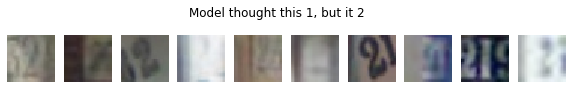

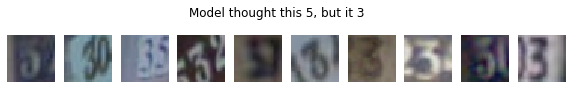

In [17]:
visualize_predicted_actual(1, 3, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 2, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(5, 3, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [48]:
def cartesian_product(arrays, num_arrays):
    la = len(arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=np.float)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, num_arrays)

In [159]:
def check_loss_accuracy(loss_history,train_history,val_history):
    plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(loss_history)
    #plt.show()
    plt.subplot(212)
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")
    plt.legend();
    plt.show()

Average loss: 1.369945, Train accuracy: 0.556667, Val accuracy: 0.690192
Average loss: 0.962551, Train accuracy: 0.697591, Val accuracy: 0.733738
Average loss: 0.844914, Train accuracy: 0.735744, Val accuracy: 0.756058
Average loss: 0.777960, Train accuracy: 0.758233, Val accuracy: 0.755034
Average loss: 0.638876, Train accuracy: 0.803245, Val accuracy: 0.811480
this 0 step : lr = 0.001, reg = 0.0,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


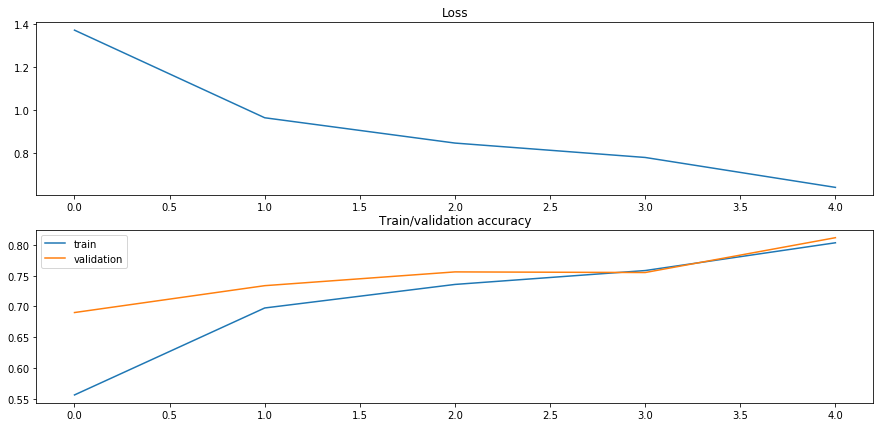

Average loss: 1.335070, Train accuracy: 0.568901, Val accuracy: 0.667599
Average loss: 0.931887, Train accuracy: 0.708016, Val accuracy: 0.718244
Average loss: 0.806359, Train accuracy: 0.749838, Val accuracy: 0.759129
Average loss: 0.743411, Train accuracy: 0.768334, Val accuracy: 0.782677
Average loss: 0.605692, Train accuracy: 0.815804, Val accuracy: 0.813801
this 1 step : lr = 0.001, reg = 0.0,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


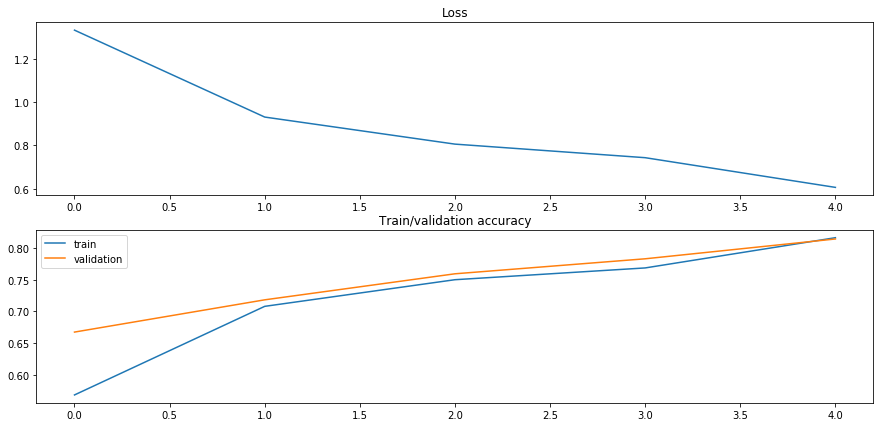

Average loss: 1.377056, Train accuracy: 0.556496, Val accuracy: 0.675449
Average loss: 0.958003, Train accuracy: 0.698017, Val accuracy: 0.731349
Average loss: 0.824726, Train accuracy: 0.743064, Val accuracy: 0.759334
Average loss: 0.751019, Train accuracy: 0.764853, Val accuracy: 0.771961
Average loss: 0.707862, Train accuracy: 0.779903, Val accuracy: 0.796601
this 2 step : lr = 0.001, reg = 0.0,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


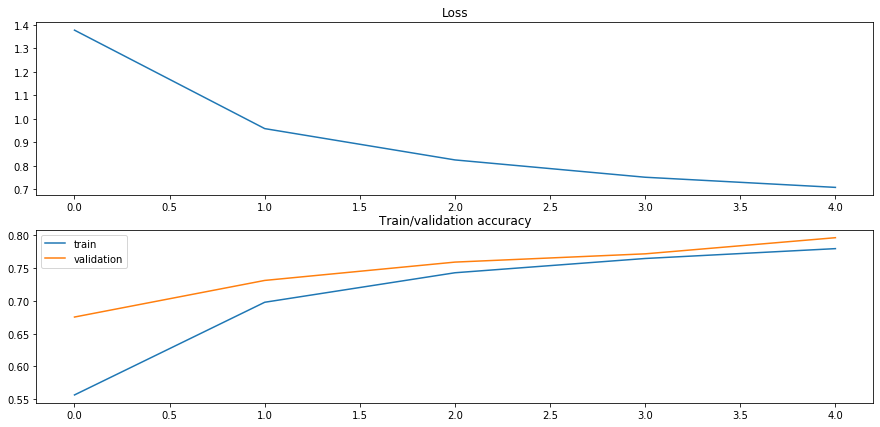

Average loss: 1.328804, Train accuracy: 0.572109, Val accuracy: 0.679203
Average loss: 0.918921, Train accuracy: 0.715200, Val accuracy: 0.752645
Average loss: 0.798274, Train accuracy: 0.750896, Val accuracy: 0.773531
Average loss: 0.732912, Train accuracy: 0.771457, Val accuracy: 0.767524
Average loss: 0.679654, Train accuracy: 0.788042, Val accuracy: 0.798785
this 3 step : lr = 0.001, reg = 0.0,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


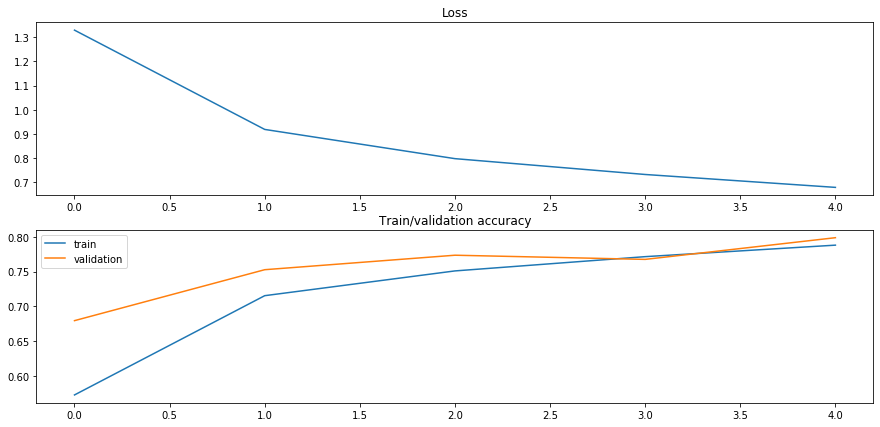

Average loss: 1.373142, Train accuracy: 0.556957, Val accuracy: 0.674493
Average loss: 0.939168, Train accuracy: 0.705952, Val accuracy: 0.733602
Average loss: 0.810812, Train accuracy: 0.748080, Val accuracy: 0.772917
Average loss: 0.736938, Train accuracy: 0.769870, Val accuracy: 0.785748
Average loss: 0.603296, Train accuracy: 0.814985, Val accuracy: 0.820217
this 4 step : lr = 0.001, reg = 1e-08,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


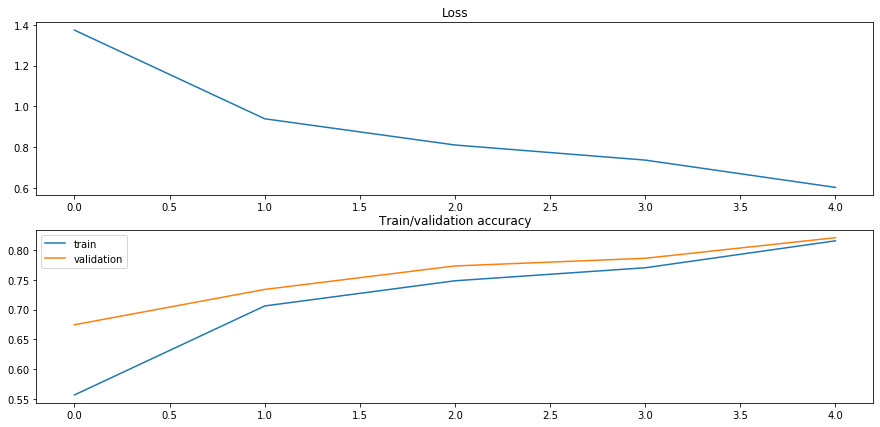

Average loss: 1.347489, Train accuracy: 0.564362, Val accuracy: 0.702000
Average loss: 0.915352, Train accuracy: 0.712282, Val accuracy: 0.750119
Average loss: 0.796767, Train accuracy: 0.751391, Val accuracy: 0.764931
Average loss: 0.731913, Train accuracy: 0.771679, Val accuracy: 0.779947
Average loss: 0.590958, Train accuracy: 0.819745, Val accuracy: 0.817896
this 5 step : lr = 0.001, reg = 1e-08,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


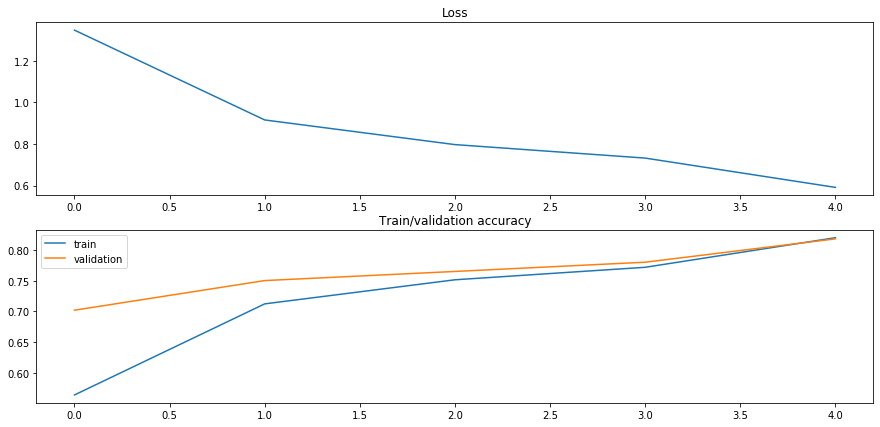

Average loss: 1.364229, Train accuracy: 0.558902, Val accuracy: 0.685960
Average loss: 0.958495, Train accuracy: 0.699519, Val accuracy: 0.731827
Average loss: 0.831511, Train accuracy: 0.740317, Val accuracy: 0.767251
Average loss: 0.757851, Train accuracy: 0.762942, Val accuracy: 0.776602
Average loss: 0.704902, Train accuracy: 0.778453, Val accuracy: 0.797693
this 6 step : lr = 0.001, reg = 1e-08,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


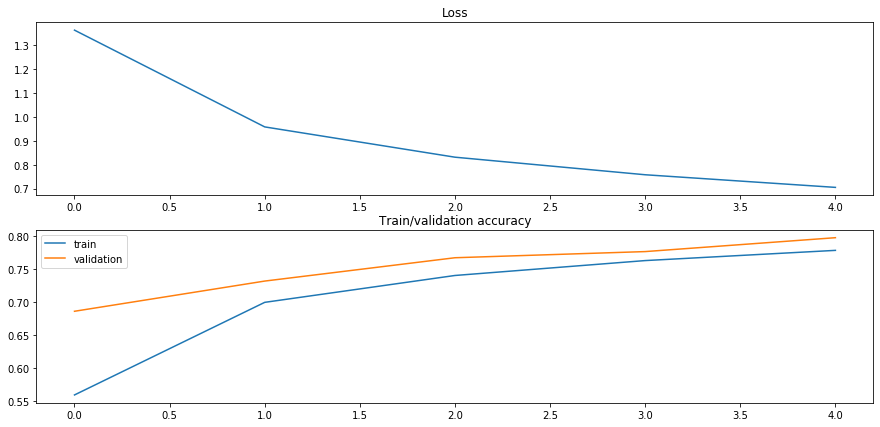

Average loss: 1.321642, Train accuracy: 0.572876, Val accuracy: 0.688349
Average loss: 0.913197, Train accuracy: 0.715012, Val accuracy: 0.749300
Average loss: 0.790272, Train accuracy: 0.754070, Val accuracy: 0.775988
Average loss: 0.725681, Train accuracy: 0.774921, Val accuracy: 0.777353
Average loss: 0.681545, Train accuracy: 0.786353, Val accuracy: 0.799604
this 7 step : lr = 0.001, reg = 1e-08,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


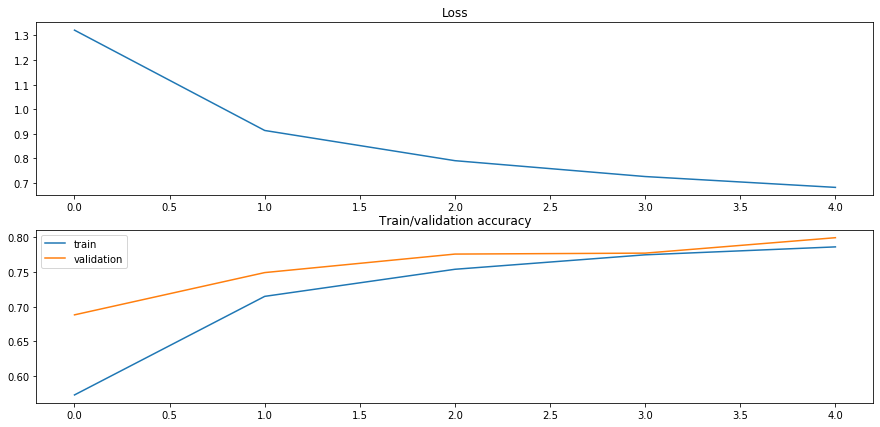

Average loss: 2.249577, Train accuracy: 0.187216, Val accuracy: 0.189543
Average loss: 2.244816, Train accuracy: 0.185800, Val accuracy: 0.189543
Average loss: 2.246053, Train accuracy: 0.185715, Val accuracy: 0.189543
Average loss: 2.245405, Train accuracy: 0.187541, Val accuracy: 0.189543
Average loss: 2.238182, Train accuracy: 0.189127, Val accuracy: 0.189543
this 8 step : lr = 0.1, reg = 0.0,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


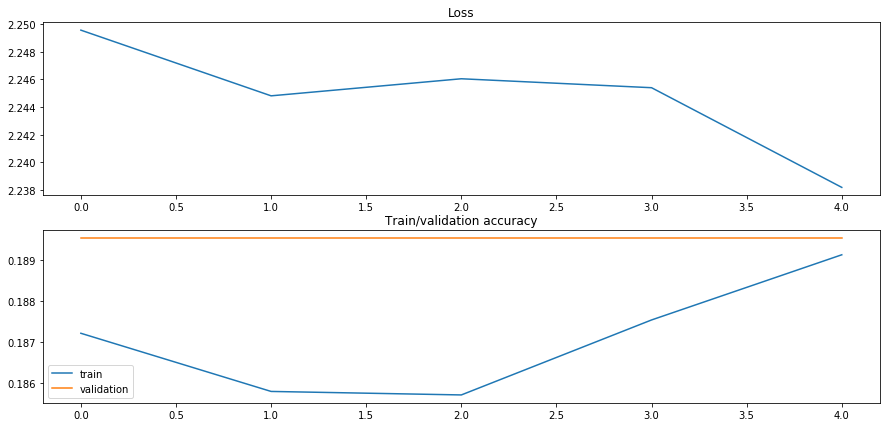

Average loss: 2.253881, Train accuracy: 0.186790, Val accuracy: 0.189543
Average loss: 2.245452, Train accuracy: 0.186278, Val accuracy: 0.189543
Average loss: 2.245056, Train accuracy: 0.187182, Val accuracy: 0.189543
Average loss: 2.245669, Train accuracy: 0.187489, Val accuracy: 0.189543
Average loss: 2.238129, Train accuracy: 0.189127, Val accuracy: 0.189543
this 9 step : lr = 0.1, reg = 0.0,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


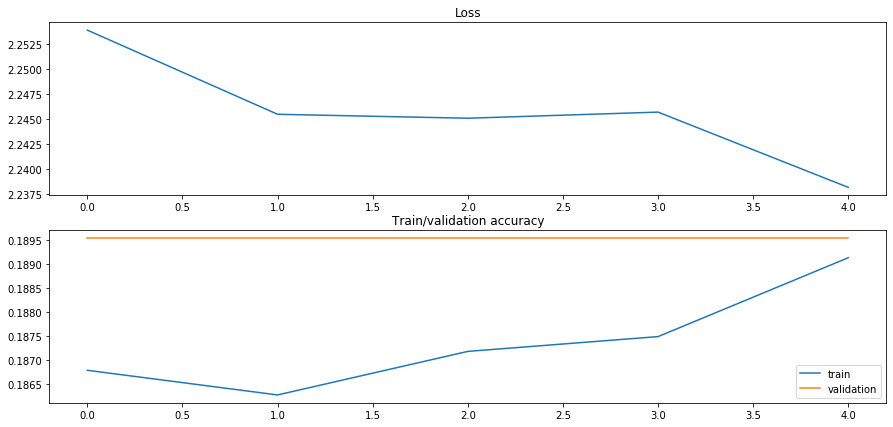

Average loss: 2.125531, Train accuracy: 0.217606, Val accuracy: 0.225582
Average loss: 2.069991, Train accuracy: 0.236972, Val accuracy: 0.259436
Average loss: 2.053631, Train accuracy: 0.242381, Val accuracy: 0.258549
Average loss: 2.043895, Train accuracy: 0.243593, Val accuracy: 0.247560
Average loss: 2.036216, Train accuracy: 0.245794, Val accuracy: 0.255068
this 10 step : lr = 0.1, reg = 0.0,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


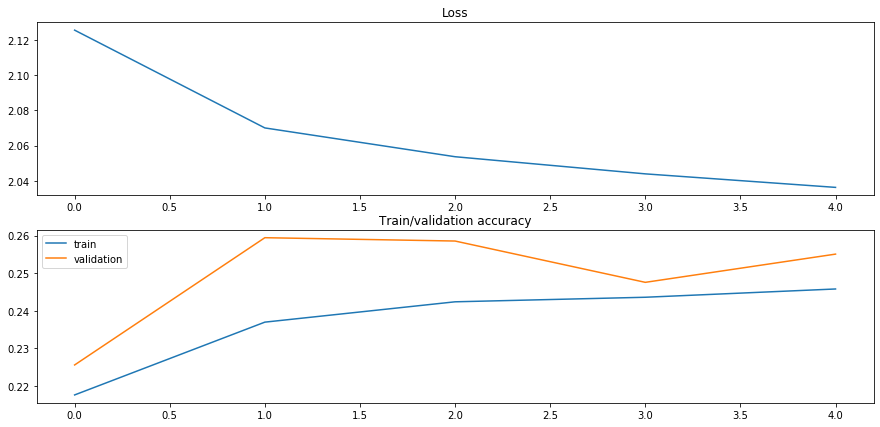

Average loss: 2.255146, Train accuracy: 0.184827, Val accuracy: 0.189543
Average loss: 2.245888, Train accuracy: 0.185152, Val accuracy: 0.189543
Average loss: 2.246090, Train accuracy: 0.184486, Val accuracy: 0.189543
Average loss: 2.246948, Train accuracy: 0.184384, Val accuracy: 0.189543
Average loss: 2.245508, Train accuracy: 0.187609, Val accuracy: 0.189543
this 11 step : lr = 0.1, reg = 0.0,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


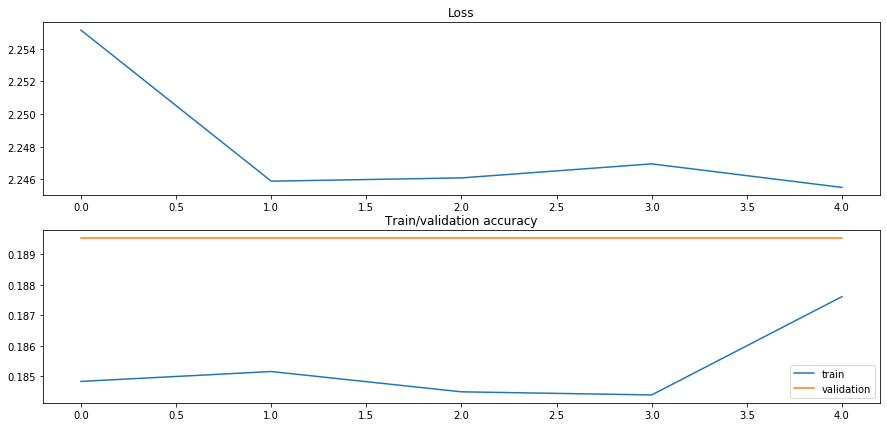

Average loss: 2.190886, Train accuracy: 0.180715, Val accuracy: 0.190840
Average loss: 2.135969, Train accuracy: 0.197181, Val accuracy: 0.207221
Average loss: 2.001284, Train accuracy: 0.236904, Val accuracy: 0.288103
Average loss: 1.910126, Train accuracy: 0.277139, Val accuracy: 0.292608
Average loss: 1.831918, Train accuracy: 0.307221, Val accuracy: 0.318818
this 12 step : lr = 0.1, reg = 1e-08,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


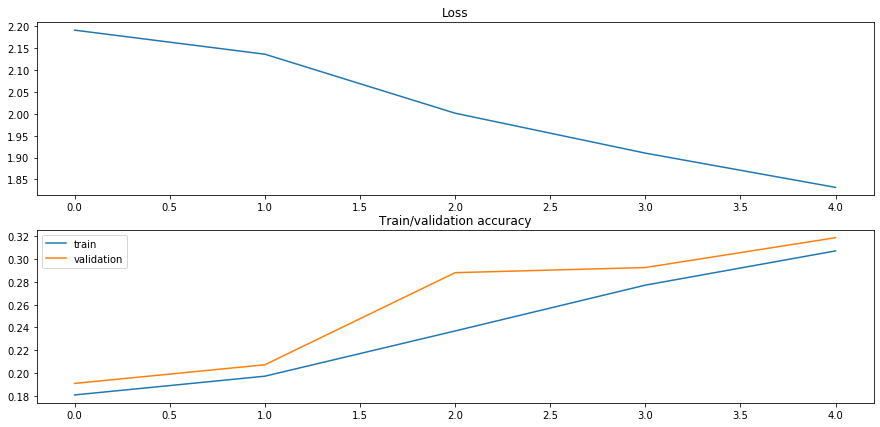

Average loss: 2.254651, Train accuracy: 0.185629, Val accuracy: 0.189543
Average loss: 2.245366, Train accuracy: 0.187216, Val accuracy: 0.189543
Average loss: 2.246867, Train accuracy: 0.187131, Val accuracy: 0.189543
Average loss: 2.245044, Train accuracy: 0.184981, Val accuracy: 0.189543
Average loss: 2.237922, Train accuracy: 0.189127, Val accuracy: 0.189543
this 13 step : lr = 0.1, reg = 1e-08,  sh_step = 4.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


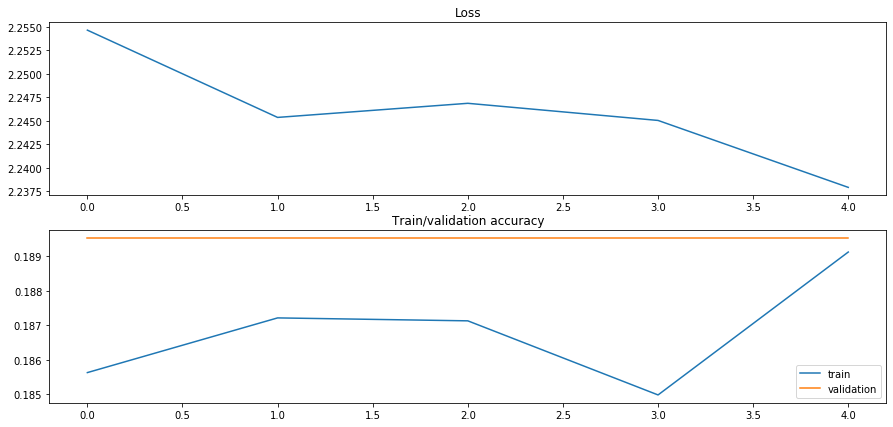

Average loss: 2.078489, Train accuracy: 0.247313, Val accuracy: 0.324142
Average loss: 1.857998, Train accuracy: 0.337508, Val accuracy: 0.356153
Average loss: 1.683061, Train accuracy: 0.401648, Val accuracy: 0.462972
Average loss: 1.518605, Train accuracy: 0.466232, Val accuracy: 0.498464
Average loss: 1.455356, Train accuracy: 0.488687, Val accuracy: 0.507406
this 14 step : lr = 0.1, reg = 1e-08,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 60, epsilon = 0.0001  


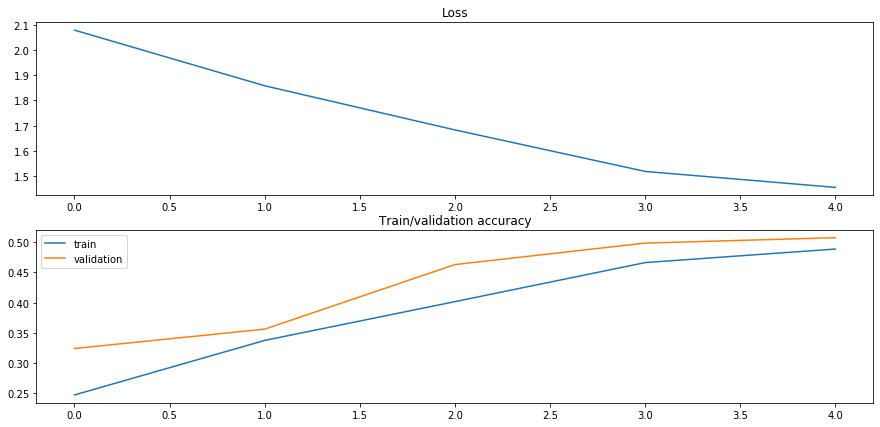

Average loss: 2.065106, Train accuracy: 0.246033, Val accuracy: 0.271859
Average loss: 1.983881, Train accuracy: 0.272191, Val accuracy: 0.293564
Average loss: 1.915559, Train accuracy: 0.291625, Val accuracy: 0.331854
Average loss: 1.811444, Train accuracy: 0.323823, Val accuracy: 0.384069
Average loss: 1.599072, Train accuracy: 0.424069, Val accuracy: 0.475531
this 15 step : lr = 0.1, reg = 1e-08,  sh_step = 6.0, hidden_size1 = 100, hiddenl_size2 = 100, epsilon = 0.0001  


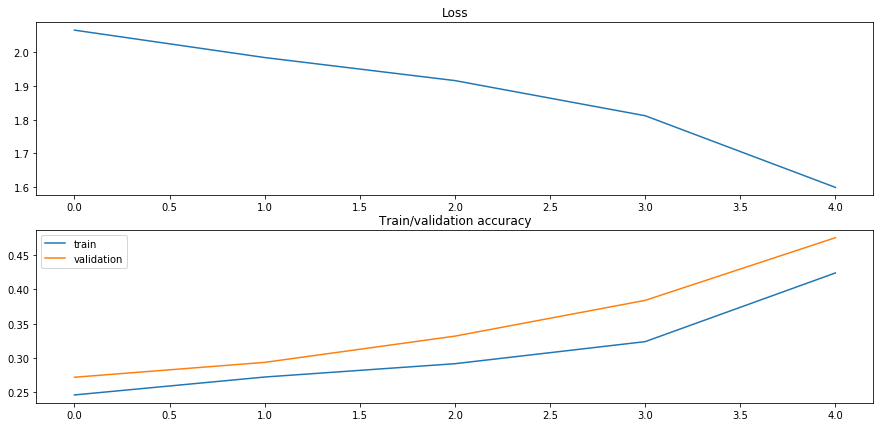

In [166]:
# Experiment here!
best_classifier_adam = None 
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

params = []

#num_epoch = 5
#learning_rates = 1e-1, 1e-3
#reg_strengths = 0, 1e-1
#sh_step = 2, 4
#hidden_layet_sizes1 = 100
#hidden_layer_sizeso = 60
#epsilons = 1e-8, 1e-7
#best = 0.001, 0.0, 4.0, 100, 60, 1e-07; test accuracy on best classifier = 0,7921

#num_epoch = 5
#learning_rates = 1e-1, 1e-4
#reg_strengths = 0, 1e-2
#sh_step = 4
#hidden_layet_sizes1 = 100
#hidden_layer_sizeso = 60
#epsilons = 1e-7, 1e-4
#best = 0.001, 0.0, 4.0, 100, 60, 0.0001; test accuracy on best classifier = 0,7926



learning_rates = np.array([1e-3, 1e-1])
reg_strengths = np.array([0, 1e-8]) #weight_decay 
sh_step = np.array([4, 6])
hidden_layer_sizes1 = np.array([100])
hidden_layer_sizes2 = np.array([60, 100])
epsilons = np.array([1e-4])
HP = (learning_rates, reg_strengths,sh_step, hidden_layer_sizes1,hidden_layer_sizes2 ,epsilons)

hyper_parametrs = cartesian_product(HP, len(HP))
for i_step, hyper_parametr in enumerate(hyper_parametrs):
    lr = hyper_parametr[0]
    reg = hyper_parametr[1]
    sh = hyper_parametr[2]
    hid_l_size1 = np.int(hyper_parametr[3])
    hid_l_size2 = np.int(hyper_parametr[4])
    eps = hyper_parametr[5]
    nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, hid_l_size1),
        nn.BatchNorm1d(hid_l_size1),
        nn.ReLU(inplace=True),
        nn.Linear(hid_l_size1, hid_l_size2),
        nn.BatchNorm1d(hid_l_size2),
        nn.ReLU(inplace=True),
        nn.Linear(hid_l_size2, 10)
             )

    optimizer = optim.Adam(nn_model.parameters(), lr=lr, betas=(0.9, 0.999), eps=eps, weight_decay=reg)
    sch=torch.optim.lr_scheduler.StepLR(optimizer, sh)
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    loss_history1, train_history1, val_history1 = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler=sch)
    print(f"this {i_step} step : lr = {lr}, reg = {reg},  sh_step = {sh}, hidden_size1 = {hid_l_size1}, hiddenl_size2 = {hid_l_size2}, epsilon = {eps}  ")
    check_loss_accuracy(loss_history1, train_history1, val_history1)
    max_val = max(val_history1)
    if max_val > best_val_accuracy:
        best_val_accuracy = max_val
        loss_history = loss_history1
        train_history = train_history1
        val_history = val_history1
        best_classifier_adam = nn_model
        params = [lr, reg, sh, hid_l_size1, hid_l_size2, eps]

In [167]:
params

[0.001, 1e-08, 4.0, 100, 60, 0.0001]

In [ ]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_classifier_adam, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)